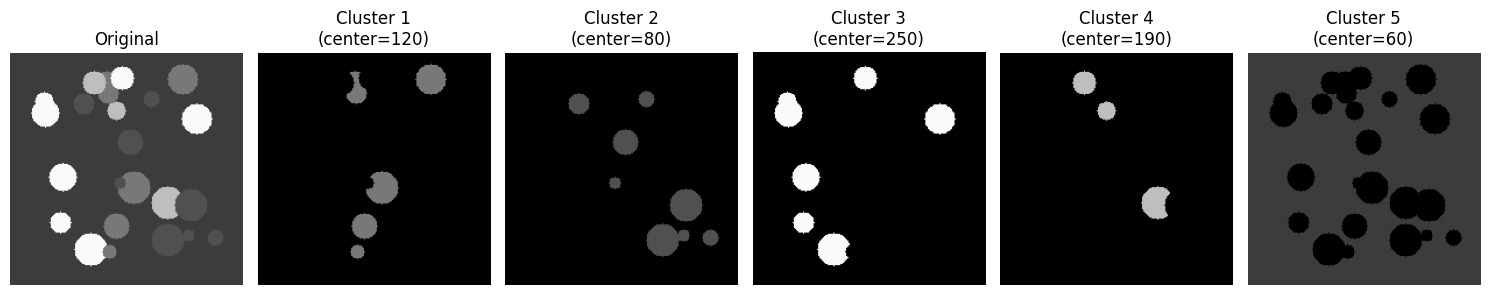

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- 模擬画像生成（明暗＋背景つき）---
np.random.seed(1)
img = np.ones((200, 200), dtype=np.uint8) * 60  # 背景（やや暗め）

# 明暗のある粒子を追加
for _ in range(25):
    y, x = np.random.randint(20, 180, 2)
    r = np.random.randint(5, 15)
    color = int(np.random.choice([80, 120, 190, 250]))  # 整数化
    cv2.circle(img, (x, y), r, color, -1)



# --- k-meansの準備 ---
Z = img.reshape((-1, 1)).astype(np.float32)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 5  # クラスタ数を5に設定

# --- k-meansの実行 ---
_, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)  # クラスタ中心の明るさ値 (0〜255)
label_2d = label.reshape(img.shape)

# --- 各クラスタを中心の明るさで塗る ---
cluster_imgs = []
for i in range(K):
    mask = (label_2d == i)
    cluster_img = np.zeros_like(img)
    cluster_img[mask] = center[i]   # クラスタ中心の輝度で塗りつぶす
    cluster_imgs.append(cluster_img)

# --- 表示 ---
fig, axes = plt.subplots(1, K+1, figsize=(15, 3))
axes[0].imshow(img, cmap='gray', vmin=0, vmax=255)
axes[0].set_title("Original")
axes[0].axis('off')

for i in range(K):
    axes[i+1].imshow(cluster_imgs[i], cmap='gray', vmin=0, vmax=255)
    axes[i+1].set_title(f"Cluster {i+1}\n(center={center[i][0]})")
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

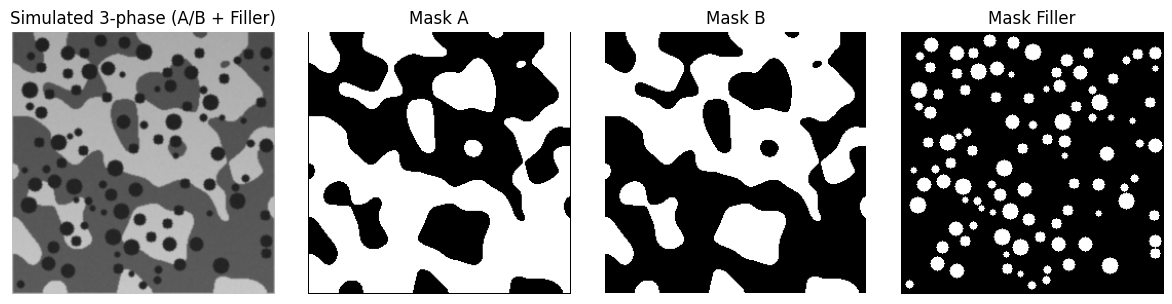

In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, binary_opening, binary_closing

# -------------------------------
# 3相（ブレンドA・ブレンドB・フィラー）画像を生成
# -------------------------------
def make_ternary_polymer(
    H=256, W=256,
    seed=1,
    # --- 構造の粗さ・分布 ---
    structure_sigma=10,         # 相分離の粗さ（大きいほどドメインが大きい）
    volfrac_A=0.5,              # 相Aの体積分率（フィラーを除いた樹脂部での比率）
    volfrac_B=0.5,              # 相Bの体積分率（= 1 - volfrac_A）
    # --- フィラー ---
    n_fillers=120,              # フィラー粒子数
    r_min=3, r_max=8,           # フィラー半径の範囲 [px]
    filler_overlap_ok=True,     # Trueならフィラー同士の重なり許容
    # --- 画素値（輝度） ---
    gray_A=80, gray_B=180, gray_F=30,   # 相A/B/フィラーの輝度（0-255）
    # --- 撮像っぽさ（オプション）---
    add_background_gradient=True,
    grad_low=0.90, grad_high=1.10,      # 背景ムラの強さ
    add_gaussian_noise=True,
    noise_sigma=3,                      # 画素ノイズ（標準偏差）
    final_blur_sigma=0.8                # 最終的なぼかし（PSFっぽさ）
):
    assert 0 < volfrac_A < 1, "volfrac_A は (0,1) の範囲で指定してください。"
    volfrac_B = 1.0 - volfrac_A

    rng = np.random.default_rng(seed)

    # --- 1) ランダムノイズ→平滑化で相の粗いパターンを作る ---
    base = rng.random((H, W))
    base = gaussian_filter(base, sigma=structure_sigma)
    base = (base - base.min()) / (base.max() - base.min() + 1e-12)  # 0-1正規化

    # --- 2) 分位点で2相に分ける（面積比を volfrac_A:volfrac_B に調整） ---
    t = np.quantile(base, volfrac_A)  # 小さい側を相A、大きい側を相Bに
    mask_A = base <= t
    mask_B = ~mask_A

    # 相境界を少し滑らかに（見た目の自然さ向上）※任意
    mask_A = binary_opening(mask_A, structure=np.ones((3,3), np.uint8))
    mask_A = binary_closing(mask_A, structure=np.ones((3,3), np.uint8))
    mask_B = ~mask_A

    # --- 3) まずは樹脂画像（2相）を作る ---
    img = np.zeros((H, W), dtype=np.float32)
    img[mask_A] = gray_A
    img[mask_B] = gray_B

    # --- 4) フィラーを描く（第3相） ---
    # フィラーの描画用マスク（重なり制御に使用）
    filler_mask = np.zeros((H, W), dtype=np.uint8)

    def can_place(y, x, r):
        if filler_overlap_ok:
            return True
        y0, y1 = max(0, y-r), min(H, y+r+1)
        x0, x1 = max(0, x-r), min(W, x+r+1)
        crop = filler_mask[y0:y1, x0:x1]
        # すでに白い（=占有）ピクセルと重なっていないか
        return (crop>0).sum() == 0

    placed = 0
    trials = 0
    max_trials = n_fillers * 20  # 詰まりやすいときの上限
    while placed < n_fillers and trials < max_trials:
        trials += 1
        y = rng.integers(r_max, H - r_max)
        x = rng.integers(r_max, W - r_max)
        r = int(rng.integers(r_min, r_max + 1))
        if not can_place(y, x, r):
            continue
        cv2.circle(img, (int(x), int(y)), r, float(gray_F), -1)
        cv2.circle(filler_mask, (int(x), int(y)), r, 255, -1)
        placed += 1

    # --- 5) 背景ムラ（勾配）・ノイズ・最終ぼかし（撮像っぽさ） ---
    if add_background_gradient:
        grad = np.linspace(grad_low, grad_high, H, dtype=np.float32)
        img = img * grad[:, None]

    if add_gaussian_noise:
        img = img + rng.normal(0, noise_sigma, img.shape).astype(np.float32)

    if final_blur_sigma and final_blur_sigma > 0:
        img = gaussian_filter(img, sigma=final_blur_sigma)

    # クリップ＆uint8
    img = np.clip(img, 0, 255).astype(np.uint8)

    # --- 返却（可視化用にマスクも返す） ---
    masks = {
        "A": mask_A.astype(np.uint8)*255,
        "B": mask_B.astype(np.uint8)*255,
        "F": filler_mask
    }
    return img, masks



img, masks = make_ternary_polymer(
    H=256, W=256,
    seed=7,
    structure_sigma=10,
    volfrac_A=0.55,       # 樹脂部のうち相A 55%, 相B 45%
    n_fillers=100,
    r_min=3, r_max=8,
    filler_overlap_ok=False,  # フィラー同士の重なりを禁止
    gray_A=85, gray_B=185, gray_F=35,
    add_background_gradient=True,
    grad_low=0.92, grad_high=1.08,
    add_gaussian_noise=True,
    noise_sigma=2.5,
    final_blur_sigma=0.7
)

# 表示（全体＋各相マスク）
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(img, cmap='gray', vmin=0, vmax=255)
axes[0].set_title("Simulated 3-phase (A/B + Filler)")
axes[0].axis('off')

axes[1].imshow(masks["A"], cmap='gray')
axes[1].set_title("Mask A")
axes[1].axis('off')

axes[2].imshow(masks["B"], cmap='gray')
axes[2].set_title("Mask B")
axes[2].axis('off')

axes[3].imshow(masks["F"], cmap='gray')
axes[3].set_title("Mask Filler")
axes[3].axis('off')

plt.tight_layout()
plt.show()


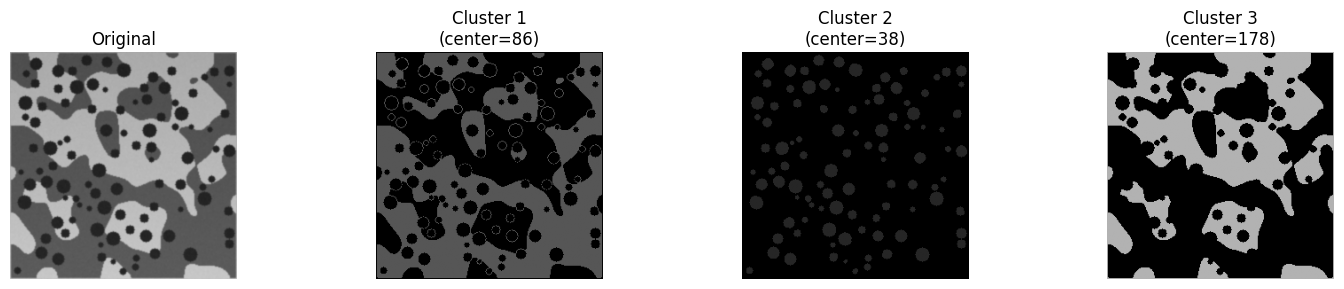

In [21]:

# --- k-meansの準備 ---
Z = img.reshape((-1, 1)).astype(np.float32)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3  # クラスタ数を5に設定

# --- k-meansの実行 ---
_, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)  # クラスタ中心の明るさ値 (0〜255)
label_2d = label.reshape(img.shape)

# --- 各クラスタを中心の明るさで塗る ---
cluster_imgs = []
for i in range(K):
    mask = (label_2d == i)
    cluster_img = np.zeros_like(img)
    cluster_img[mask] = center[i]   # クラスタ中心の輝度で塗りつぶす
    cluster_imgs.append(cluster_img)

# --- 表示 ---
fig, axes = plt.subplots(1, K+1, figsize=(15, 3))
axes[0].imshow(img, cmap='gray', vmin=0, vmax=255)
axes[0].set_title("Original")
axes[0].axis('off')

for i in range(K):
    axes[i+1].imshow(cluster_imgs[i], cmap='gray', vmin=0, vmax=255)
    axes[i+1].set_title(f"Cluster {i+1}\n(center={center[i][0]})")
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()